In [52]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns




In [5]:
!pip install keras-tuner

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),



)


Found 4752 files belonging to 9 classes.


In [8]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [9]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



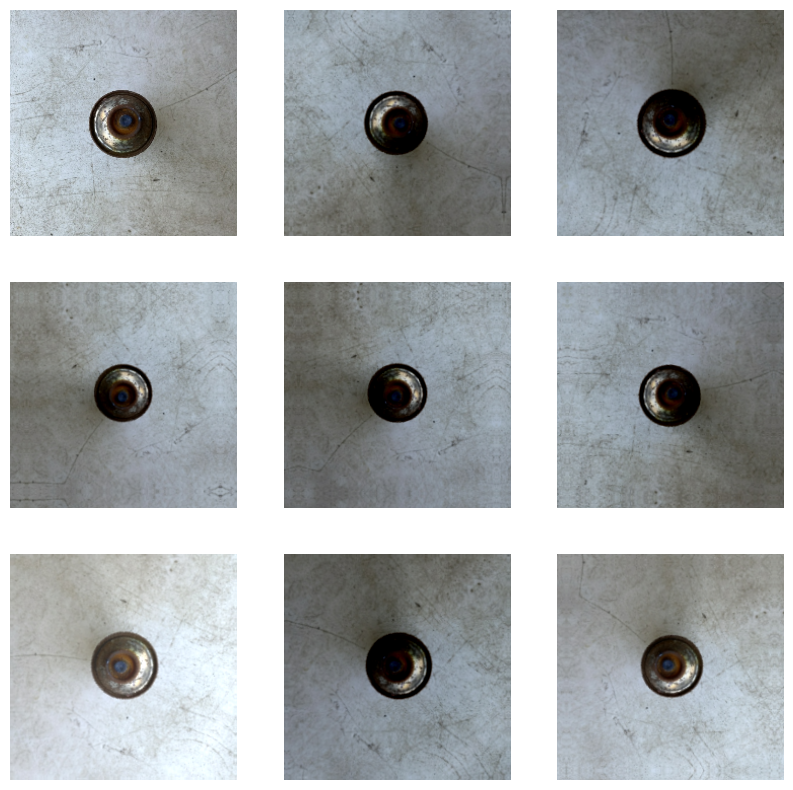

In [10]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()


visualize_dataset(dataset, class_names)

In [11]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [12]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [13]:

train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size


train_dataset = dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)

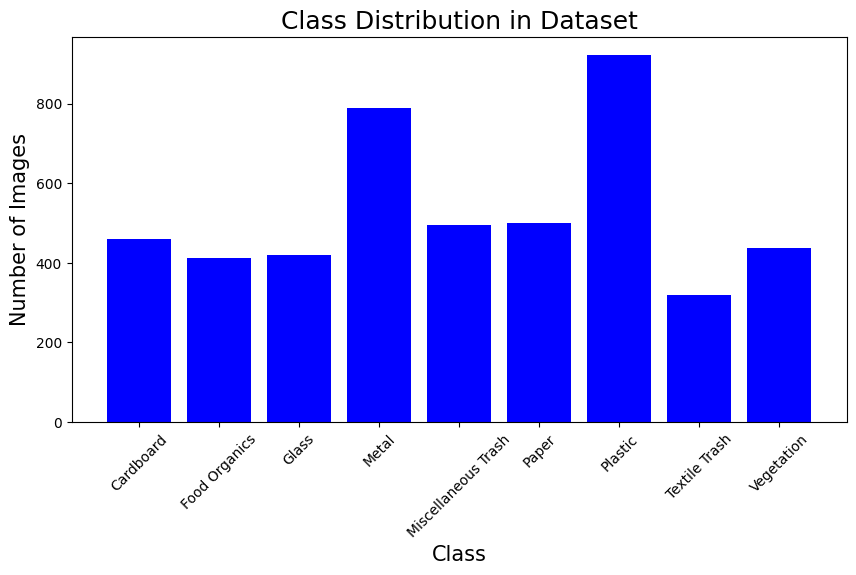

In [14]:



class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [15]:

train_labels = []


for batch in train_dataset.as_numpy_iterator():
    labels = batch[1]


    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)

    train_labels.extend(labels)


train_labels = np.array(train_labels)


class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.074935400516796), 1: np.float64(1.2795078815840062), 2: np.float64(1.275095785440613), 3: np.float64(0.6809903826478412), 4: np.float64(1.1239446133063153), 5: np.float64(1.0718196457326892), 6: np.float64(0.5680150196279229), 7: np.float64(1.6218323586744638), 8: np.float64(1.1966918374685365)}


In [16]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [41]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:

        return float(lr * tf.math.exp(-0.1))


In [26]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [45]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = True




model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")
])



model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss= categorical_focal_loss(),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)
lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=45,  callbacks=[ lr_scheduler, reduce_lr])



Epoch 1/45
104/104 ━━━━━━━━━━━━━━━━━━━━ 114s 478ms/step - accuracy: 0.1514 - loss: 0.6119 - val_accuracy: 0.0966 - val_loss: 0.4475 - learning_rate: 1.0000e-04
Epoch 2/45
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 439ms/step - accuracy: 0.3492 - loss: 0.3708 - val_accuracy: 0.1321 - val_loss: 0.4405 - learning_rate: 1.0000e-04
Epoch 3/45
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 438ms/step - accuracy: 0.4566 - loss: 0.2699 - val_accuracy: 0.1974 - val_loss: 0.4205 - learning_rate: 1.0000e-04
Epoch 4/45
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 448ms/step - accuracy: 0.5315 - loss: 0.2249 - val_accuracy: 0.2741 - val_loss: 0.3490 - learning_rate: 1.0000e-04
Epoch 5/45
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 447ms/step - accuracy: 0.6008 - loss: 0.1876 - val_accuracy: 0.3594 - val_loss: 0.3179 - learning_rate: 1.0000e-04
Epoch 6/45
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 441ms/step - accuracy: 0.6332 - loss: 0.1616 - val_accuracy: 0.2415 - val_loss: 0.3983 - learning_rate: 9.0484e-05
Epoch 7/45
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 4

In [46]:

y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)


y_pred = np.argmax(y_pred_probs, axis=1)

print("True labels shape:", y_true.shape)
print("Predicted labels shape:", y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
True labels shape: (704, 9)
Predicted labels shape: (704,)


In [47]:

if y_pred.ndim > 1:
    y_pred = np.argmax(y_pred, axis=1)


if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59        71
           1       0.80      0.73      0.76        59
           2       0.81      0.67      0.74        52
           3       0.70      0.81      0.75       110
           4       0.80      0.45      0.58        82
           5       0.63      0.95      0.76        77
           6       0.89      0.68      0.77       143
           7       0.73      0.80      0.76        40
           8       0.72      1.00      0.84        70

    accuracy                           0.73       704
   macro avg       0.74      0.74      0.73       704
weighted avg       0.75      0.73      0.73       704



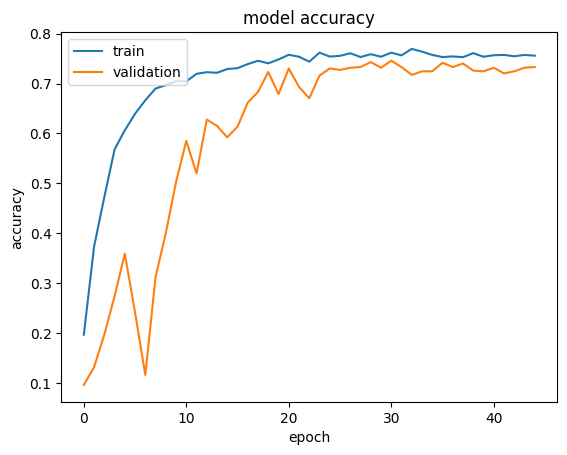

In [48]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

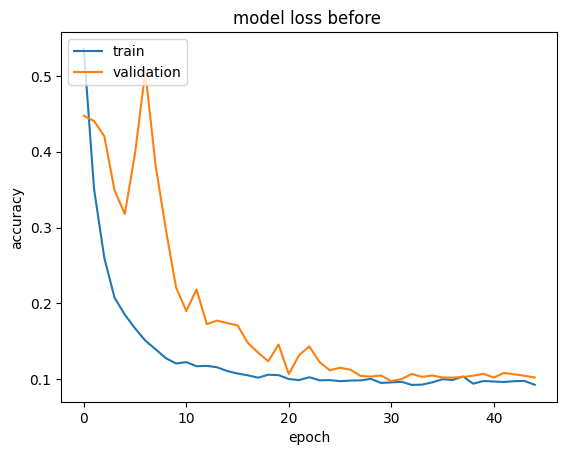

In [49]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss before ")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

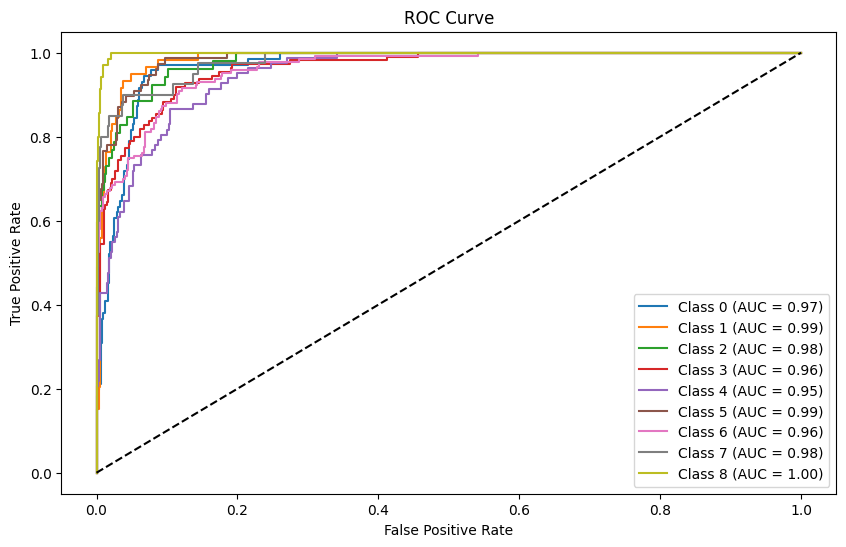

In [50]:

num_classes = 9
y_true_one_hot = to_categorical(y_true, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

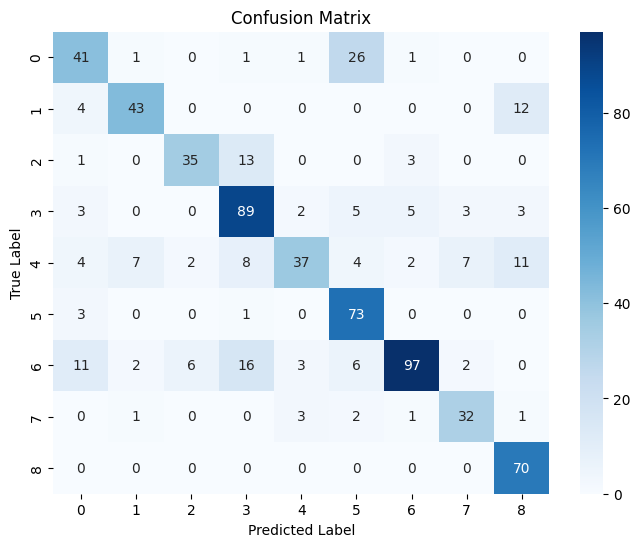

In [53]:

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [54]:

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 726ms/step - accuracy: 0.7451 - loss: 0.0919
Test Accuracy: 0.7542
Test Loss: 0.0933


In [55]:


def build_model(hp):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    trainable = hp.Boolean('trainable', default=False)
    base_model.trainable = trainable

    if trainable:
        num_unfrozen_layers = hp.Int("unfreeze_layers", min_value=10, max_value=30, step=5)
        for layer in base_model.layers[-num_unfrozen_layers:]:
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(hp.Int("units", min_value=64, max_value=512, step=64),
                     activation=hp.Choice("activation", ["relu", "elu", "swish"])),
        layers.Dense(9, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5, 1e-6])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [56]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

In [57]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[early_stopping, lr_scheduler])


best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 5 Complete [00h 26m 04s]
val_accuracy: 0.7620738744735718

Best val_accuracy So Far: 0.7620738744735718
Total elapsed time: 01h 31m 52s


In [58]:
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[ lr_scheduler]
)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 114s 467ms/step - accuracy: 0.2157 - loss: 2.3486 - val_accuracy: 0.0810 - val_loss: 2.2866 - learning_rate: 1.0000e-04
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 445ms/step - accuracy: 0.5331 - loss: 1.3403 - val_accuracy: 0.1108 - val_loss: 2.2964 - learning_rate: 1.0000e-04
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 449ms/step - accuracy: 0.6323 - loss: 0.9930 - val_accuracy: 0.1648 - val_loss: 2.1945 - learning_rate: 1.0000e-04
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 439ms/step - accuracy: 0.6867 - loss: 0.8370 - val_accuracy: 0.2614 - val_loss: 1.9609 - learning_rate: 1.0000e-04
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.7364 - loss: 0.7095 - val_accuracy: 0.2159 - val_loss: 2.2379 - learning_rate: 1.0000e-04
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 440ms/step - accuracy: 0.7612 - loss: 0.6194 - val_accuracy: 0.5767 - val_loss: 1.2636 - learning_rate: 1.0000e-04
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 4

In [59]:
tuner.results_summary()


Results summary
Results in hyperparameter_tuning/efficientnet_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
trainable: True
dropout_rate_1: 0.4
units_1: 512
activation_1: relu
dropout_rate_2: 0.3
units_2: 256
activation_2: swish
learning_rate: 0.0001
unfreeze_layers: 10
Score: 0.7620738744735718

Trial 3 summary
Hyperparameters:
trainable: True
dropout_rate_1: 0.3
units_1: 512
activation_1: relu
dropout_rate_2: 0.5
units_2: 192
activation_2: relu
learning_rate: 0.0001
unfreeze_layers: 10
Score: 0.7173295319080353

Trial 0 summary
Hyperparameters:
trainable: True
dropout_rate_1: 0.5
units_1: 256
activation_1: elu
dropout_rate_2: 0.6000000000000001
units_2: 128
activation_2: elu
learning_rate: 0.001
unfreeze_layers: 10
Score: 0.25

Trial 1 summary
Hyperparameters:
trainable: False
dropout_rate_1: 0.3
units_1: 256
activation_1: elu
dropout_rate_2: 0.6000000000000001
units_2: 128
activation_2: elu
learning_rate: 1e-06
unfree

In [60]:
from sklearn.metrics import classification_report


y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_probs.extend(preds)


y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)


y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [61]:


print(classification_report(y_true, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.73      0.87      0.79        68
           1       0.87      0.94      0.90        64
           2       0.75      0.92      0.83        53
           3       0.81      0.90      0.85       106
           4       0.89      0.68      0.77        84
           5       0.83      0.90      0.87        83
           6       0.89      0.62      0.73       136
           7       0.78      0.90      0.84        40
           8       0.88      0.97      0.93        70

    accuracy                           0.83       704
   macro avg       0.83      0.86      0.83       704
weighted avg       0.84      0.83      0.82       704



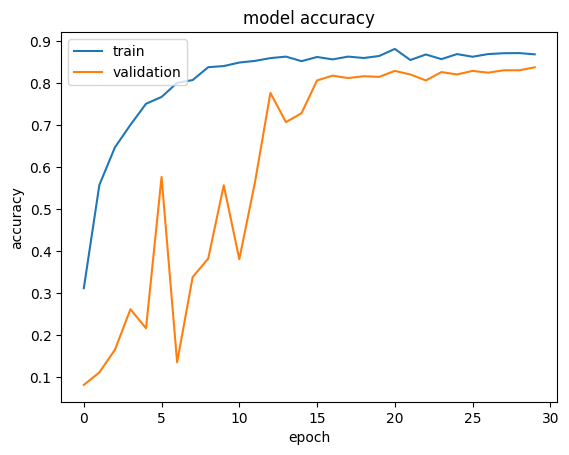

In [62]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
best_model.save("best_efficientnet_model.keras", include_optimizer=False)


In [ ]:
model = load_model("best_efficientnet_model.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")